In [94]:
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
import time
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, concatenate
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
#import model_management
from scipy.special import comb
import datetime
import codecs, json
from itertools import combinations
%load_ext autoreload
%autoreload 1
%aimport environmental_density
%aimport data_processing
%aimport plotting
from environmental_density import get_density_periodic
from data_processing import log_weighted_mse, normal_weighted_mse, stellar_mass_weighted_mse, \
                            halo_mass_weighted_loss_wrapper, load_galfile, divide_train_data, \
                            normalise_data, get_test_score, predict_test_points
from plotting import *

np.random.seed(999)
random.seed(999)

#loss_func_dict = {
#    'mse': 'mse',
#    'mae': 'mae',
#    'weighted_mse_1': weighted_mse_1,
#    'stellar_mass_weighted_mse': stellar_mass_weighted_mse
#}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
if run_on_cpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Set parameter string

In [ ]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

In [ ]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))
print(np.min(x_test_norm, 0))
print(np.max(x_test_norm, 0))

In [ ]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

In [ ]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

## Load an existing model

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


In [ ]:
importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)

## Get the standard pictures

25000/25000 [==============================] - 4s 159us/step


<function matplotlib.pyplot.show>

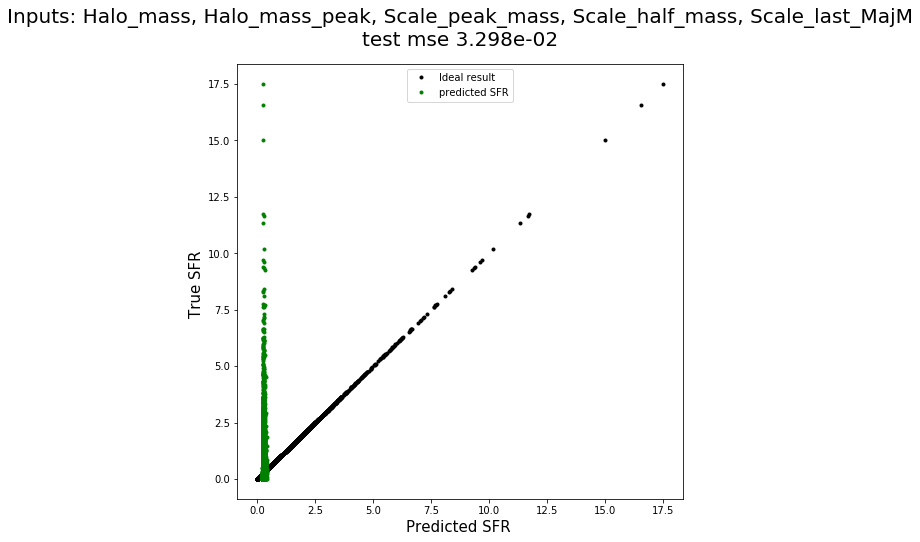

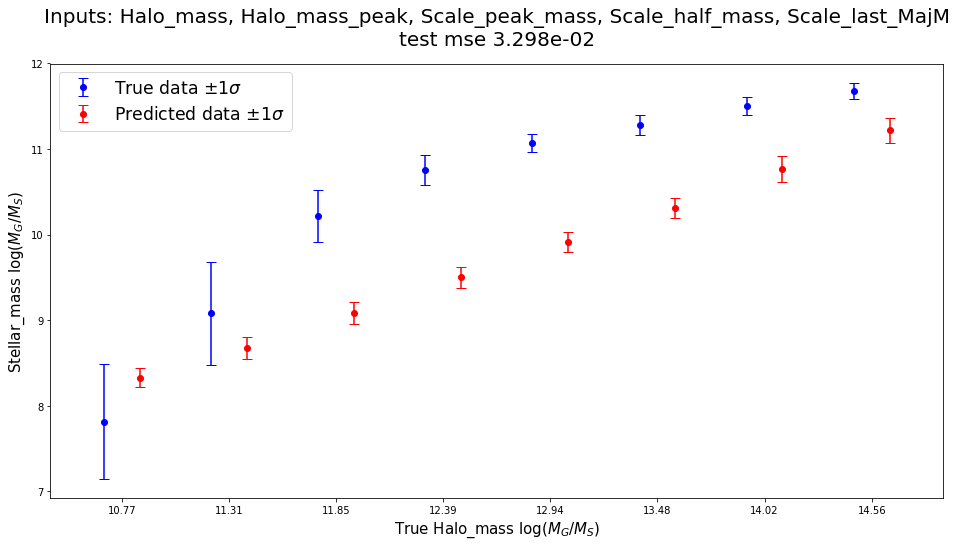

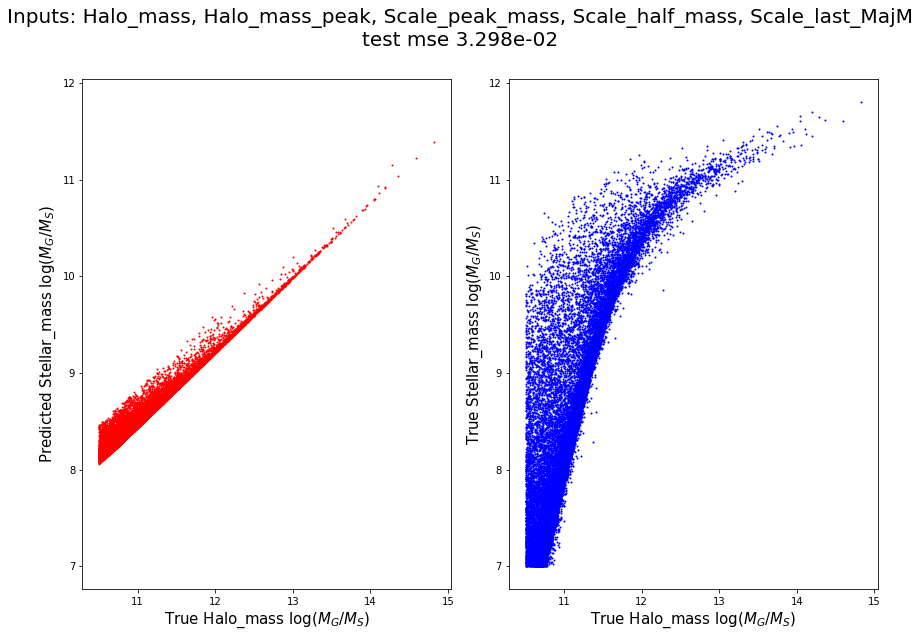

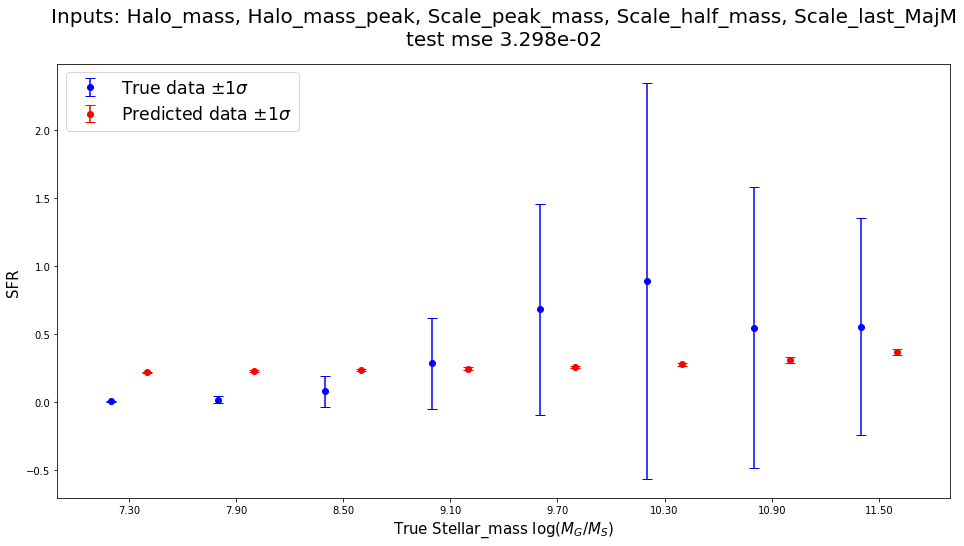

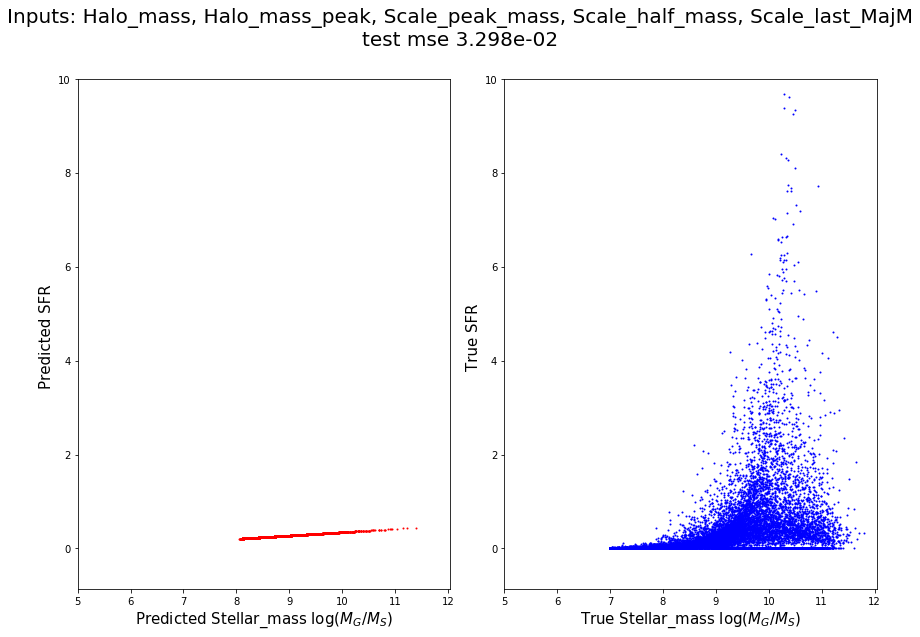

In [108]:
norm_scores = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'],
                                               verbose=1)
tot_score = norm_scores[0]
title = 'Inputs: %s\ntest mse %.3e' % (', '.join(input_features), tot_score)
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title)
fig3 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'Stellar_mass', title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None)
fig4 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, 'SFR', 
                                binning_feat = 'Stellar_mass', title=title)
fig5 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Stellar_mass', 
                                    y_axis_feature = 'SFR', title=title, y_max = 10, y_min = None,
                                    x_min = 5, x_max = None)
plt.show

In [ ]:
### Save the figures
fig1.savefig(fig_dir + '_'.join(input_features) + '_true_pred_sfr_scatter.png', bbox_inches = 'tight')
fig2.savefig(fig_dir + '_'.join(input_features) + '_boxplot_stellar_mass.png', bbox_inches = 'tight')
fig3.savefig(fig_dir + '_'.join(input_features) + '_scatter_comp_halo_vs_stellar_mass.png', bbox_inches = 'tight')
fig4.savefig(fig_dir + '_'.join(input_features) + '_boxplot_sfr.png', bbox_inches = 'tight')
fig5.savefig(fig_dir + '_'.join(input_features) + '_scatter_comp_stellar_mass_vs_sfr.png', bbox_inches = 'tight')

## Create a new model

In [105]:
### General parameters
nr_steps = 1e4
batch_size = 2.5e4
total_set_size = 3e5 # how many examples will be used for training+validation+testing
train_size = 2.5e5
val_size = 2.5e4
test_size = 2.5e4
norm = 'none' # 'none',   'zero_mean_unit_std',   'zero_to_one'
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Scale_last_MajM']
output_features = ['Stellar_mass', 'SFR']
#loss_func = halo_mass_weighted_loss
#loss_func_dict = {   # 'mse', weighted_mse_1, 'mae', stellar_mass_weighted_mse
#    'Stellar_mass': stellar_mass_weighted_mse,
#    'SFR': normal_weighted_mse
#} 
early_stop_patience = 200
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-8

nr_epochs = nr_steps * batch_size / train_size

### Network parameters
nLayers = 8
activationFunction = 'tanh'
neuronsPerLayer = 8
reg_strength = 1e-5


In [106]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfile()
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                       int(total_set_size), int(train_size), int(val_size), int(test_size))
galaxies = None
training_data_dict = normalise_data(training_data_dict, norm)

In [107]:
# Create model
halo_mass_input = Input(shape=(1,), name = 'halo_mass_input')
others_input = Input(shape=(len(input_features)-1,), name = 'others_input')

for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    if i == 0:
        x = concatenate([halo_mass_input, others_input])
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
        
output_layers = []
for feat in output_features:
#    out_pre_act = Dense(1)(x)
#    output_layers.append(LeakyReLU(alpha = 0.1, name = feat)(out_pre_act))
    output_layers.append(Dense(1, kernel_regularizer=regularizers.l2(reg_strength), name = feat)(x))

model = Model([halo_mass_input, others_input], output_layers)
model.compile(optimizer = 'adam', loss = halo_mass_weighted_loss_wrapper(halo_mass_input))

earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                    validation_data = (training_data_dict['input_val_dict'], 
                    training_data_dict['output_val_dict']), 
                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)

Train on 250000 samples, validate on 25000 samples
Epoch 1/1000
250000/250000 [==============================] - 3s 13us/step - loss: 0.0033 - Stellar_mass_loss: 0.0027 - SFR_loss: 1.7080e-05 - val_loss: 0.0032 - val_Stellar_mass_loss: 0.0026 - val_SFR_loss: 1.9180e-05
Epoch 2/1000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0031 - Stellar_mass_loss: 0.0025 - SFR_loss: 2.1346e-05 - val_loss: 0.0030 - val_Stellar_mass_loss: 0.0024 - val_SFR_loss: 2.7739e-05
Epoch 3/1000
250000/250000 [==============================] - 0s 2us/step - loss: 0.0028 - Stellar_mass_loss: 0.0022 - SFR_loss: 3.5974e-05 - val_loss: 0.0026 - val_Stellar_mass_loss: 0.0020 - val_SFR_loss: 5.2151e-05
Epoch 4/1000
250000/250000 [==============================] - 0s 2us/step - loss: 0.0024 - Stellar_mass_loss: 0.0018 - SFR_loss: 7.5501e-05 - val_loss: 0.0021 - val_Stellar_mass_loss: 0.0015 - val_SFR_loss: 1.1403e-04
Epoch 5/1000
250000/250000 [==============================] - 0s 2us/step - 

250000/250000 [==============================] - 0s 2us/step - loss: 3.3295e-04 - Stellar_mass_loss: 2.9311e-05 - SFR_loss: 1.6680e-05 - val_loss: 3.3107e-04 - val_Stellar_mass_loss: 2.9384e-05 - val_SFR_loss: 1.7703e-05
Epoch 37/1000
250000/250000 [==============================] - 0s 2us/step - loss: 3.2757e-04 - Stellar_mass_loss: 2.9296e-05 - SFR_loss: 1.6680e-05 - val_loss: 3.2579e-04 - val_Stellar_mass_loss: 2.9375e-05 - val_SFR_loss: 1.7702e-05
Epoch 38/1000
250000/250000 [==============================] - 0s 2us/step - loss: 3.2237e-04 - Stellar_mass_loss: 2.9292e-05 - SFR_loss: 1.6678e-05 - val_loss: 3.2068e-04 - val_Stellar_mass_loss: 2.9366e-05 - val_SFR_loss: 1.7701e-05
Epoch 39/1000
250000/250000 [==============================] - 0s 2us/step - loss: 3.1733e-04 - Stellar_mass_loss: 2.9266e-05 - SFR_loss: 1.6679e-05 - val_loss: 3.1574e-04 - val_Stellar_mass_loss: 2.9343e-05 - val_SFR_loss: 1.7701e-05
Epoch 40/1000
250000/250000 [==============================] - 0s 2us/step

Epoch 71/1000
250000/250000 [==============================] - 0s 2us/step - loss: 2.1854e-04 - Stellar_mass_loss: 2.8864e-05 - SFR_loss: 1.6647e-05 - val_loss: 2.1866e-04 - val_Stellar_mass_loss: 2.8940e-05 - val_SFR_loss: 1.7670e-05
Epoch 72/1000
250000/250000 [==============================] - 0s 2us/step - loss: 2.1675e-04 - Stellar_mass_loss: 2.8845e-05 - SFR_loss: 1.6646e-05 - val_loss: 2.1689e-04 - val_Stellar_mass_loss: 2.8928e-05 - val_SFR_loss: 1.7670e-05
Epoch 73/1000
250000/250000 [==============================] - 0s 2us/step - loss: 2.1501e-04 - Stellar_mass_loss: 2.8840e-05 - SFR_loss: 1.6645e-05 - val_loss: 2.1518e-04 - val_Stellar_mass_loss: 2.8916e-05 - val_SFR_loss: 1.7669e-05
Epoch 74/1000
250000/250000 [==============================] - 0s 2us/step - loss: 2.1332e-04 - Stellar_mass_loss: 2.8822e-05 - SFR_loss: 1.6645e-05 - val_loss: 2.1351e-04 - val_Stellar_mass_loss: 2.8909e-05 - val_SFR_loss: 1.7668e-05
Epoch 75/1000
250000/250000 [==============================]

Epoch 106/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.7631e-04 - Stellar_mass_loss: 2.8478e-05 - SFR_loss: 1.6614e-05 - val_loss: 1.7698e-04 - val_Stellar_mass_loss: 2.8543e-05 - val_SFR_loss: 1.7637e-05
Epoch 107/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.7551e-04 - Stellar_mass_loss: 2.8465e-05 - SFR_loss: 1.6613e-05 - val_loss: 1.7619e-04 - val_Stellar_mass_loss: 2.8553e-05 - val_SFR_loss: 1.7636e-05
Epoch 108/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.7473e-04 - Stellar_mass_loss: 2.8453e-05 - SFR_loss: 1.6612e-05 - val_loss: 1.7542e-04 - val_Stellar_mass_loss: 2.8536e-05 - val_SFR_loss: 1.7635e-05
Epoch 109/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.7397e-04 - Stellar_mass_loss: 2.8444e-05 - SFR_loss: 1.6611e-05 - val_loss: 1.7465e-04 - val_Stellar_mass_loss: 2.8521e-05 - val_SFR_loss: 1.7634e-05
Epoch 110/1000
250000/250000 [==========================

Epoch 141/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.5483e-04 - Stellar_mass_loss: 2.8148e-05 - SFR_loss: 1.6585e-05 - val_loss: 1.5567e-04 - val_Stellar_mass_loss: 2.8206e-05 - val_SFR_loss: 1.7607e-05
Epoch 142/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.5436e-04 - Stellar_mass_loss: 2.8138e-05 - SFR_loss: 1.6585e-05 - val_loss: 1.5520e-04 - val_Stellar_mass_loss: 2.8216e-05 - val_SFR_loss: 1.7606e-05
Epoch 143/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.5389e-04 - Stellar_mass_loss: 2.8118e-05 - SFR_loss: 1.6584e-05 - val_loss: 1.5475e-04 - val_Stellar_mass_loss: 2.8232e-05 - val_SFR_loss: 1.7606e-05
Epoch 144/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.5343e-04 - Stellar_mass_loss: 2.8125e-05 - SFR_loss: 1.6583e-05 - val_loss: 1.5428e-04 - val_Stellar_mass_loss: 2.8189e-05 - val_SFR_loss: 1.7605e-05
Epoch 145/1000
250000/250000 [==========================

Epoch 176/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.4118e-04 - Stellar_mass_loss: 2.7861e-05 - SFR_loss: 1.6563e-05 - val_loss: 1.4211e-04 - val_Stellar_mass_loss: 2.7961e-05 - val_SFR_loss: 1.7585e-05
Epoch 177/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.4086e-04 - Stellar_mass_loss: 2.7858e-05 - SFR_loss: 1.6563e-05 - val_loss: 1.4179e-04 - val_Stellar_mass_loss: 2.7949e-05 - val_SFR_loss: 1.7585e-05
Epoch 178/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.4054e-04 - Stellar_mass_loss: 2.7845e-05 - SFR_loss: 1.6562e-05 - val_loss: 1.4148e-04 - val_Stellar_mass_loss: 2.7968e-05 - val_SFR_loss: 1.7584e-05
Epoch 179/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.4023e-04 - Stellar_mass_loss: 2.7843e-05 - SFR_loss: 1.6562e-05 - val_loss: 1.4116e-04 - val_Stellar_mass_loss: 2.7935e-05 - val_SFR_loss: 1.7583e-05
Epoch 180/1000
250000/250000 [==========================

Epoch 211/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.3172e-04 - Stellar_mass_loss: 2.7628e-05 - SFR_loss: 1.6547e-05 - val_loss: 1.3270e-04 - val_Stellar_mass_loss: 2.7707e-05 - val_SFR_loss: 1.7569e-05
Epoch 212/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.3150e-04 - Stellar_mass_loss: 2.7621e-05 - SFR_loss: 1.6546e-05 - val_loss: 1.3248e-04 - val_Stellar_mass_loss: 2.7710e-05 - val_SFR_loss: 1.7569e-05
Epoch 213/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.3127e-04 - Stellar_mass_loss: 2.7608e-05 - SFR_loss: 1.6546e-05 - val_loss: 1.3226e-04 - val_Stellar_mass_loss: 2.7691e-05 - val_SFR_loss: 1.7568e-05
Epoch 214/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.3105e-04 - Stellar_mass_loss: 2.7604e-05 - SFR_loss: 1.6546e-05 - val_loss: 1.3204e-04 - val_Stellar_mass_loss: 2.7680e-05 - val_SFR_loss: 1.7567e-05
Epoch 215/1000
250000/250000 [==========================

Epoch 246/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.2506e-04 - Stellar_mass_loss: 2.7407e-05 - SFR_loss: 1.6534e-05 - val_loss: 1.2607e-04 - val_Stellar_mass_loss: 2.7483e-05 - val_SFR_loss: 1.7557e-05
Epoch 247/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.2490e-04 - Stellar_mass_loss: 2.7399e-05 - SFR_loss: 1.6534e-05 - val_loss: 1.2592e-04 - val_Stellar_mass_loss: 2.7454e-05 - val_SFR_loss: 1.7556e-05
Epoch 248/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.2474e-04 - Stellar_mass_loss: 2.7387e-05 - SFR_loss: 1.6534e-05 - val_loss: 1.2576e-04 - val_Stellar_mass_loss: 2.7472e-05 - val_SFR_loss: 1.7556e-05
Epoch 249/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.2459e-04 - Stellar_mass_loss: 2.7382e-05 - SFR_loss: 1.6534e-05 - val_loss: 1.2561e-04 - val_Stellar_mass_loss: 2.7472e-05 - val_SFR_loss: 1.7556e-05
Epoch 250/1000
250000/250000 [==========================

Epoch 281/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.2040e-04 - Stellar_mass_loss: 2.7167e-05 - SFR_loss: 1.6524e-05 - val_loss: 1.2145e-04 - val_Stellar_mass_loss: 2.7223e-05 - val_SFR_loss: 1.7546e-05
Epoch 282/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.2030e-04 - Stellar_mass_loss: 2.7163e-05 - SFR_loss: 1.6524e-05 - val_loss: 1.2135e-04 - val_Stellar_mass_loss: 2.7207e-05 - val_SFR_loss: 1.7546e-05
Epoch 283/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.2019e-04 - Stellar_mass_loss: 2.7153e-05 - SFR_loss: 1.6523e-05 - val_loss: 1.2123e-04 - val_Stellar_mass_loss: 2.7227e-05 - val_SFR_loss: 1.7545e-05
Epoch 284/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.2008e-04 - Stellar_mass_loss: 2.7144e-05 - SFR_loss: 1.6523e-05 - val_loss: 1.2112e-04 - val_Stellar_mass_loss: 2.7228e-05 - val_SFR_loss: 1.7545e-05
Epoch 285/1000
250000/250000 [==========================

Epoch 316/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1721e-04 - Stellar_mass_loss: 2.6911e-05 - SFR_loss: 1.6512e-05 - val_loss: 1.1827e-04 - val_Stellar_mass_loss: 2.6985e-05 - val_SFR_loss: 1.7535e-05
Epoch 317/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1714e-04 - Stellar_mass_loss: 2.6902e-05 - SFR_loss: 1.6512e-05 - val_loss: 1.1820e-04 - val_Stellar_mass_loss: 2.6993e-05 - val_SFR_loss: 1.7535e-05
Epoch 318/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1706e-04 - Stellar_mass_loss: 2.6898e-05 - SFR_loss: 1.6512e-05 - val_loss: 1.1812e-04 - val_Stellar_mass_loss: 2.6961e-05 - val_SFR_loss: 1.7533e-05
Epoch 319/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1699e-04 - Stellar_mass_loss: 2.6890e-05 - SFR_loss: 1.6511e-05 - val_loss: 1.1805e-04 - val_Stellar_mass_loss: 2.6970e-05 - val_SFR_loss: 1.7534e-05
Epoch 320/1000
250000/250000 [==========================

Epoch 351/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1505e-04 - Stellar_mass_loss: 2.6624e-05 - SFR_loss: 1.6498e-05 - val_loss: 1.1612e-04 - val_Stellar_mass_loss: 2.6692e-05 - val_SFR_loss: 1.7519e-05
Epoch 352/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1500e-04 - Stellar_mass_loss: 2.6624e-05 - SFR_loss: 1.6498e-05 - val_loss: 1.1608e-04 - val_Stellar_mass_loss: 2.6727e-05 - val_SFR_loss: 1.7520e-05
Epoch 353/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1495e-04 - Stellar_mass_loss: 2.6621e-05 - SFR_loss: 1.6497e-05 - val_loss: 1.1602e-04 - val_Stellar_mass_loss: 2.6655e-05 - val_SFR_loss: 1.7518e-05
Epoch 354/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1491e-04 - Stellar_mass_loss: 2.6604e-05 - SFR_loss: 1.6497e-05 - val_loss: 1.1597e-04 - val_Stellar_mass_loss: 2.6648e-05 - val_SFR_loss: 1.7518e-05
Epoch 355/1000
250000/250000 [==========================

Epoch 386/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1360e-04 - Stellar_mass_loss: 2.6303e-05 - SFR_loss: 1.6479e-05 - val_loss: 1.1466e-04 - val_Stellar_mass_loss: 2.6360e-05 - val_SFR_loss: 1.7498e-05
Epoch 387/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1356e-04 - Stellar_mass_loss: 2.6291e-05 - SFR_loss: 1.6479e-05 - val_loss: 1.1463e-04 - val_Stellar_mass_loss: 2.6370e-05 - val_SFR_loss: 1.7500e-05
Epoch 388/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1352e-04 - Stellar_mass_loss: 2.6283e-05 - SFR_loss: 1.6478e-05 - val_loss: 1.1460e-04 - val_Stellar_mass_loss: 2.6346e-05 - val_SFR_loss: 1.7497e-05
Epoch 389/1000
250000/250000 [==============================] - 0s 2us/step - loss: 1.1349e-04 - Stellar_mass_loss: 2.6274e-05 - SFR_loss: 1.6477e-05 - val_loss: 1.1458e-04 - val_Stellar_mass_loss: 2.6309e-05 - val_SFR_loss: 1.7497e-05
Epoch 390/1000
250000/250000 [==========================

KeyboardInterrupt: 

In [68]:
weights = model.layers[5].get_weights()
print(weights)

[array([[ 1.82381138e-01, -6.60839975e-02,  2.23247007e-01,
        -1.06463753e-01, -2.43862599e-01, -1.22376800e-01,
         2.16591060e-01, -1.95440292e-01, -5.38775958e-02,
         1.31829411e-01,  2.09662274e-01,  9.96776745e-02,
         2.60979325e-01,  2.06811503e-01, -1.56063378e-01,
        -1.96524754e-01, -1.57166764e-01, -2.57728517e-01,
         1.15074955e-01, -1.48675404e-03, -2.84196049e-01,
         1.45840570e-02, -1.89742863e-01, -6.88918307e-03,
        -1.47688299e-01,  4.31725867e-02,  3.15533936e-01,
        -3.27905357e-01,  2.99662888e-01, -4.63180318e-02],
       [-2.71014541e-01,  4.97853607e-02,  1.73847616e-01,
         3.01352274e-02,  3.00082147e-01, -2.66001374e-01,
        -5.32104112e-02,  2.22163033e-02,  1.79896086e-01,
         2.17982650e-01, -2.37029195e-01, -2.65558451e-01,
        -1.08374417e-01, -1.62320584e-01,  3.35715488e-02,
         2.09343493e-01,  4.97765876e-02, -1.39980167e-01,
        -1.31015167e-01,  1.66320756e-01, -3.18259448e

#### Plot loss history

In [87]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_Stellar_mass_loss', 'val_SFR_loss', 'loss', 'Stellar_mass_loss', 'SFR_loss'])


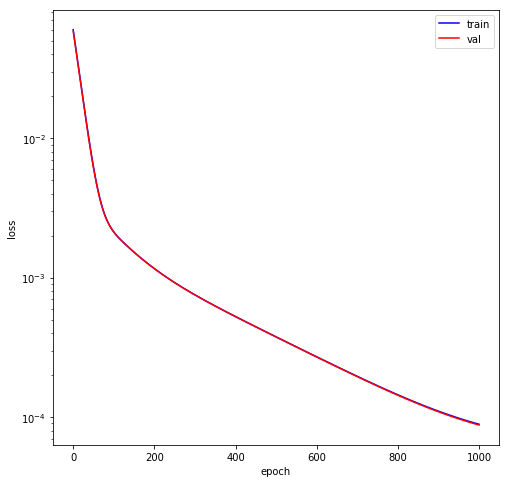

In [103]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Batch runs

#### Do a batch run to see which input parameters gives the best score

In [ ]:
total_set_size = 300000
train_size = 250000
val_size = 25000
test_size = 25000

core_input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass']
tested_input_features = ['Concentration', 'Type', 'Scale_half_mass', 
                 'Scale_last_MajM', 'Environmental_density']
output_features = ['Stellar_mass', 'SFR']
nr_extra_params_list = [2]
nr_runs_per_comb = 3

nLayers = 10
activationFunction = 'tanh'
neuronsPerLayer = 30
loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
norm = 'zero_to_one' # 'none',   'zero_mean_unit',   'zero_to_one'

nr_steps = 1e4
batch_size = 4e4

verb = 0 # prints progress to stdout

nr_epochs = nr_steps * batch_size / train_size
parameter_dictionary = {
    'fixed_input_features': core_input_features,
    'tested_input_features': tested_input_features,
    'output_features': output_features,
    'nr_extra_parameter_combinations': nr_extra_params_list,
    'nr_steps': [nr_steps],
    'batch_size': [batch_size],
    'nr_epochs': [nr_epochs],
    'nr_training_samples': [train_size],
    'nr_validation_samples': [val_size],
    'nr_test_samples': [test_size],
    'data_normalization': norm,
    'activation_function': activationFunction,
    'neurons_per_layer': [neuronsPerLayer],
    'nr_hidden_layers': [nLayers],
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing three objects. The first one is ' + \
    'the input parameters. The second one is the mse test scores obtained for the different runs evaluated on the ' +\
    'normed units and the original units of the data set (original only if norm is \'none\'). The third one is the ' +\
    'loss histories for the different runs [training_loss, validation_loss] evaluated on the normalised data.'
}
results_list = [parameter_dictionary]
nr_combs_total = 0
for nr_extra_params in nr_extra_params_list:
    nr_combs_total += comb(len(tested_input_features), nr_extra_params)
comb_counter = 0 # to keep track of how many combinations I've gone through

with open('model_comparisons/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile
    galaxies, data_keys, unit_dict = load_galfile()
    
    for i_nr_extra_params, nr_extra_params in enumerate(nr_extra_params_list):
        
        extra_param_combs = list(combinations(tested_input_features, nr_extra_params))
        
        date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
        f.write(date_string_proper + '    Testing %d extra parameters. %d/%d extra parameter count tested. \n\n' %
                (nr_extra_params, i_nr_extra_params+1, len(nr_extra_params_list)))
        f.flush()
    
        for i_comb, param_comb in enumerate(extra_param_combs):
            input_features = core_input_features.copy()
            input_features.extend(param_comb)
            
            # prepare the training data
            training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                                   total_set_size, train_size, val_size, test_size)
            training_data_dict = normalise_data(training_data_dict, norm)
            
            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
            comb_counter += 1
            f.write(date_string_proper + '        Testing combination %d/%d. \n\n' % (comb_counter, nr_combs_total))
            f.flush()
            
            original_scores = []
            if not norm == 'none':
                normed_scores = []
            histories = []

            for i_run in range(nr_runs_per_comb):

                # create model
                model = Sequential()
                model.add(Dense(neuronsPerLayer, input_dim = len(input_features), activation = activationFunction))

                for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
                    model.add(Dense(neuronsPerLayer, activation = activationFunction))

                model.add(Dense(len(output_features)))

                # Compile model
                earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, \
                          verbose=1, mode='auto')
                callbacks_list = [earlystop]
                model.compile(loss=loss_func_dict[loss_function], optimizer='adam')

                # Fit the model
                if norm == 'none':
                    history = model.fit(training_data_dict['x_train'], training_data_dict['y_train'], 
                                        validation_data=(training_data_dict['x_val'], training_data_dict['y_val']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    orig_score = model.evaluate(x=training_data_dict['x_test'], y=training_data_dict['y_test'],
                                               verbose=verb)
                    original_scores.append(orig_score)
                    
                else:
                    history = model.fit(training_data_dict['x_train_norm'] , training_data_dict['y_train_norm'], 
                                        validation_data=(training_data_dict['x_val_norm'], 
                                        training_data_dict['y_val_norm']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    norm_score = model.evaluate(x=training_data_dict['x_test_norm'], y=training_data_dict['y_test_norm'],
                                               verbose=verb)
                    normed_scores.append(norm_score)
                    orig_score = get_test_score(model, training_data_dict, norm)
                    original_scores.append(orig_score)
                    
                histories.append([history.history['loss'], history.history['val_loss']])
                
            if norm == 'none':
                scores = original_scores
            else:
                scores = [normed_scores, original_scores]
                
            results_list.append([input_features, scores, histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

#### Save the result

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '5_total_inputs'
with open('model_comparisons/' + custom_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:

#print(train_loss)
print('Lowest train/val/test loss: %.2f, %.2f, %.2f' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

#### Load a batch run result

In [ ]:
### Load a result
loaded_list_string = '5_total_inputs'
with open('model_comparisons/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

print(results_list[0])

#### Plot the results

In [ ]:
print(len(results_list[1][1]))
print(results_list[1][1])

In [ ]:
### Plot the loss histories to make sure that the best performance was reached

for comb_nr, lst in enumerate(results_list[1:]):

    title = lst[0]
    train_loss = lst[2][0][0]
    val_loss = lst[2][0][1]
    test_loss = lst[1][0]

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for i_run in range(len(test_loss)):
        train_loss = lst[2][i_run][0]
        val_loss = lst[2][i_run][1]
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(results_list[1][0])

In [ ]:
### Get the X best performing input parameters
get_normed_scores = 1
top_nr_of_parameter_combs = 10
column_widths = [0.2, 0.05]
test_results = []
val_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    if get_normed_scores:
        best_test = np.amin(lst[1][0])
    else:
        best_test = np.amin(lst[1][1])
        
#    val_losses = []
#    for i_run in range(len(lst[1])):
#        val_losses.append(lst[2][i_run][1])
        
    test_results.append(best_test)
#    val_results.append(np.amin(val_losses))
    
best_test_indices = np.argsort(test_results)
#best_val_indices = np.argsort(val_results)

fig1362 = plt.figure(figsize=(16,8))

ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best test mse\n(normalised units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_test_indices[i]+1][0][:3])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][3:])
    
    table_vals.append([inputs, '%.3e' % 
                      (np.amin(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

In [ ]:
fig1362.savefig(fig_dir + '5_total_inputs' + '_param_comb_scores_test.png', bbox_inches = 'tight')

In [ ]:
### Plot best validation scores
fig2 = plt.figure(figsize=(16,8))


ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best val mse\n(scaled units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_val_indices[i]+1][0])
    
    table_vals.append([inputs, '%.3f' % 
                      (val_results[best_val_indices[i]])])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)

ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, relu on output: False, 10 layers, 10 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'], 
          ), fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1])

#plt.tight_layout(h_pad=30)

plt.show()

In [ ]:
fig2.savefig(fig_dir + '2018-05-12--13-36-02_param_comb_scores_val.png', bbox_inches = 'tight')

In [ ]:
### Find out how a parameter affects the result
collabel = ('Input parameter', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')
first_col_width = .1
last_col_width = .02
column_widths = [first_col_width]
for i in range(10):
    column_widths.append(last_col_width)
tab_rows = []
row_colours = []

for param in results_list[0]['tested_input_features']:
    
    tab_row = [param]
    row_colour = ['w']

    for i, ind in enumerate(best_test_indices[:10]):
        inputs = results_list[ind+1][0]
        if param in inputs:
            tab_row.append('Yes')
            row_colour.append('g')
        else:
            tab_row.append('No')
            row_colour.append('r')

    tab_rows.append(tab_row)
    row_colours.append(row_colour)
        
fig8845 = plt.figure(figsize=(16,8))

ax = plt.subplot(111)

the_table = ax.table(cellText=tab_rows,colLabels=collabel,colWidths=column_widths,
                     cellColours=row_colours,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer'
          % (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'])+
           '\nFixed input parameters: %s\nOrdering based on test scores (normalised units)' % 
          (', '.join(results_list[0]['fixed_input_features'])), fontsize=20)
#plt.title('Ordering based on validation scores', fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 0.8])

#ax.axis('tight')
ax.axis('off')

plt.show()
    

In [ ]:
fig8845.savefig(fig_dir + '5_total_inputs' + '_param_importance_test.png', bbox_inches = 'tight')

## Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(train_loss, 'b')
plt.plot(val_loss, 'r')
plt.yscale('log')
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Evaluate the model

In [ ]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

## Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

## Scatterplots and boxplots

In [ ]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
halo_min_mass = np.amin(galaxies[:,6])
halo_max_mass = np.amax(galaxies[:,6])
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

x_test = training_data_dict['x_test']
y_test = training_data_dict['y_test']

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    ### Plot 1
    fig1 = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    plt.show
    
    ### Plot 2 - boxplot
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,i], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,i], predictedY[:,i].flatten(), bins=bin_edges)
    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
        
    fig2 = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every boxplot adds 2 boxes, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.boxplot([sorted_true_y_data[iBin], sorted_pred_y_data[iBin]] , positions = bin_pos, widths = 0.9)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    #plt.text(12,7,'Left: true data. Right: predicted data.', fontsize=20)
    
    if feat == 'SFR':
        ax.axhline(y=0, linestyle='--')
    
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    
    plt.show()        

In [ ]:
fig1.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
fig2.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

## Scatterplots and plots with errorbars

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
halo_min_mass = np.amin(galaxies[:,6])
halo_max_mass = np.amax(galaxies[:,6])
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

x_test = training_data_dict['x_test']
y_test = training_data_dict['y_test']

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    
    ### Plot 1
    fig1 = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    plt.show
    
    ### Plot 2 - Spread of the distribution
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,0], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,0], predictedY[:,i].flatten(), bins=bin_edges)

    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
    
    # get standard deviations of the binned values
    stds_true = np.zeros((nBins))
    stds_pred = np.zeros((nBins))
    for iBin in range(nBins):
        stds_true[iBin] = np.std(sorted_true_y_data[iBin])
        stds_pred[iBin] = np.std(sorted_pred_y_data[iBin])
        
    fig2 = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every plot adds 2 distributions, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.errorbar(bin_pos[0], bin_means_true[0][iBin], yerr=stds_true[iBin], fmt = 'bo', capsize=5)
        plt.errorbar(bin_pos[1], bin_means_pred[0][iBin], yerr=stds_pred[iBin], fmt = 'ro', capsize=5)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    plt.legend(['True data $\pm 1 \sigma$', 'Predicted data $\pm 1 \sigma$'], loc='upper left', fontsize='xx-large')
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    
    plt.show()

In [ ]:
fig1.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
fig2.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

In [ ]:
#print(predictedY.flatten())
#bin_means = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10)
#bin_stds = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10, statistic=GetSTD)
#print(bin_means[0])
#print(bin_stds[0])

## Plot SFR vs Stellar mass

In [ ]:
### Save the figure
fig.savefig(fig_dir+'bp_sfr_to_stellar_mass_inputs_' + '_and_'.join(input_features)+
            '_with_'+param_string+'.png', bbox_inches = 'tight')

### Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Testing functions

In [ ]:
### TESTING
coordinates = galaxies[:1000, :3]
halo_masses = np.power(10, galaxies[:1000, 6])
nr_points = np.shape(coordinates)[0]

nr_neighbours_wanted = 30
box_sides = np.array([200, 200, 200])

neigh_densities = get_density_periodic(coordinates, halo_masses, nr_neighbours_wanted, 
                                                                 box_sides, nr_points, verbatim=True)
print(neigh_densities)